# START


## Setup

In [45]:
!%pip install pandas numpy yfinance matplotlib seaborn ta scipy tqdm -q

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from ta.volatility import AverageTrueRange # Keep for ATR-based stops
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
import json

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ All imports successful!")

zsh:fg:1: no job control in this shell.
✅ All imports successful!


## Configuration and Data Classes

In [46]:
@dataclass
class StrategyConfig:
    """
    Strategy configuration parameters for Earnings Surprise
    """
    # Strategy parameters
    holding_period: int = 5  # Hold for 5 trading days
    
    # Risk management
    stop_loss_pct: float = 0.05      # 5% (Earnings can be volatile)
    trailing_stop_pct: float = 0.03  # 3%
    risk_per_trade: float = 0.02     # Risk 2% of portfolio per trade
    max_position_size: float = 0.2   # Max 20% of portfolio in one stock
    min_position_size: float = 0.05  # Min 5%
    
    # Portfolio parameters
    initial_capital: float = 500000.0  # $500K
    transaction_cost: float = 0.001    # 0.1% per trade
    max_positions: int = 10            # Max 10 concurrent positions
    
    # Data parameters
    train_start: str = "2015-01-01" # Start date
    train_end: str = "2024-12-31"   # End date


class EventType(Enum):
    """Types of market events for our strategy"""
    EARNINGS_BEAT = "earnings_beat"       # Surprise > 0
    EARNINGS_MISS = "earnings_miss"       # Surprise < 0
    STOP_LOSS_HIT = "stop_loss_hit"
    TRAILING_STOP_HIT = "trailing_stop_hit"
    HOLDING_PERIOD_EXIT = "holding_period_exit"


@dataclass
class Event:
    """Represents a market event"""
    timestamp: datetime
    event_type: EventType
    symbol: str
    data: Dict
    priority: int = 0
    
    def __repr__(self):
        return f"Event({self.timestamp.date()}, {self.symbol}, {self.event_type.value}, priority={self.priority})"


@dataclass
class Position:
    """Represents an open position"""
    symbol: str
    side: str  # 'LONG' or 'SHORT'
    entry_price: float
    entry_time: datetime
    entry_date_index: int # The index of the trading_dates list
    shares: float
    stop_loss: float
    trailing_stop: float
    highest_price: float = 0.0
    lowest_price: float = float('inf')
    
    @property
    def value(self) -> float:
        """Current position value"""
        return self.shares * self.entry_price


@dataclass
class Trade:
    """Completed trade record"""
    symbol: str
    side: str
    entry_time: datetime
    exit_time: datetime
    entry_price: float
    exit_price: float
    shares: float
    pnl: float
    pnl_pct: float
    reason: str


print("✅ Configuration and data classes defined!")

✅ Configuration and data classes defined!


## Data Preparation

In [47]:
# ============================================================================
# 2. DATA PREPARATION
# ============================================================================

def get_spy_stocks(top_n: int = 50) -> List[str]:
    """
    Get SPY constituent stocks
    For this example, we'll use a static list of liquid S&P 500 stocks
    """
    spy_stocks = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK.B', 'JNJ', 'JPM', 'V', 'PG', 'XOM',
        'BAC', 'MA', 'T', 'DIS', 'HD', 'INTC', 'VZ', 'PFE', 'MRK', 'CSCO',
        'KO', 'PEP', 'WFC', 'CMCSA', 'C', 'CVX', 'NFLX', 'ABT', 'ORCL', 'COST',
        'BA', 'MCD', 'IBM', 'UNH', 'PM', 'GE', 'HON', 'QCOM', 'AMGN', 'MDT',
        'UPS', 'BMY', 'SBUX', 'TXN', 'LOW', 'MMM', 'LMT', 'CAT', 'NKE', 'GS'
    ]
    return spy_stocks[:top_n]

# SPY_STOCKS = get_spy_stocks(50)
# print(f"✅ Using {len(SPY_STOCKS)} SPY stocks:")
# print(f"   {', '.join(SPY_STOCKS[:10])}...")

def prepare_stock_data(df_price: pd.DataFrame, df_earnings: pd.DataFrame, config: StrategyConfig) -> pd.DataFrame:
    """
    Merges earnings data onto price data and calculates required indicators.
    The "Signal" (1 or -1) is placed on the *day after* the earnings report.
    """
    
    # 1. Process Price Data
    # DO NOT reset_index here. We need the DatetimeIndex.
    data = pd.DataFrame(index=df_price.index)
    data['Open'] = df_price['Open']
    data['Close'] = df_price['Close']
    data['High'] = df_price['High']
    data['Low'] = df_price['Low']
    
    # Ensure index is timezone-naive
    if data.index.tz is not None:
        data.index = data.index.tz_convert(None)
        
    # --- THIS IS THE FIX from our last conversation ---
    # Normalize the index to midnight (e.g., '2025-10-27 00:00:00')
    # This allows it to match the 'Trade Date' column.
    data.index = data.index.normalize()
    # --------------------------------------------------
    
    # Calculate ATR for stops (ATR window = 14)
    atr_window = 14
    atr = AverageTrueRange(data['High'], data['Low'], data['Close'], window=atr_window, fillna=True)
    data['ATR'] = atr.average_true_range()
    data['ATR_Pct'] = data['ATR'] / data['Close']
    
    # 2. Process Earnings Data
    if df_earnings is None or df_earnings.empty:
        data['Signal'] = np.nan
        return data.iloc[atr_window:] 
    
    try:
        df_earnings = df_earnings.reset_index()
        df_earnings['Earnings Date'] = pd.to_datetime(df_earnings['Earnings Date'])
        
        if df_earnings['Earnings Date'].dt.tz is not None:
            df_earnings['Earnings Date'] = df_earnings['Earnings Date'].dt.tz_convert(None)
            
        df_earnings = df_earnings.dropna(subset=['Reported EPS', 'EPS Estimate'])
        if df_earnings.empty:
            raise Exception("No valid earnings data after dropna")
            
        df_earnings['Surprise'] = df_earnings['Reported EPS'] - df_earnings['EPS Estimate']
        df_earnings['Signal'] = np.where(df_earnings['Surprise'] > 0, 1, -1)
        
        # This creates the 'Trade Date' at midnight
        df_earnings['Trade Date'] = df_earnings['Earnings Date'].dt.normalize() + pd.Timedelta(days=1)
        
        # 3. Merge
        df_merged = pd.merge(
            data, 
            df_earnings[['Trade Date', 'Surprise','Signal']], 
            left_index=True,  # <-- FIX 2: Use left_index=True
            right_on='Trade Date', 
            how='left'
        )
        
        # Set index back to the price data's index
        df_merged.set_index(data.index, inplace=True)
        df_merged.drop(columns=['Trade Date'], inplace=True, errors='ignore')
        
        # Drop initial NaN rows from ATR calculation
        df_merged = df_merged.iloc[atr_window:]
        print(df_merged.head()) # You can uncomment this for testing
        return df_merged
        
    except Exception as e:
        print(f"  ⚠️  Error processing earnings data: {e}") # Good to uncomment this
        data['Signal'] = np.nan
        return data.iloc[atr_window:]

print("✅ Data preparation function defined!")

✅ Data preparation function defined!


## Event Detector

In [48]:
class EventDetector:
    """Detects earnings events from prepared data"""
    
    def __init__(self, config: StrategyConfig):
        self.config = config
        
    def detect_events(self, symbol: str, current_data: pd.Series, prev_data: Optional[pd.Series]) -> List[Event]:
        """Check if today is an earnings trade day"""
        events = []
        timestamp = current_data.name
        
        # Check for a signal on the current day
        # current_data['Signal'] will be 1 (Beat), -1 (Miss), or NaN
        if pd.notna(current_data['Signal']):
            event_type = EventType.EARNINGS_BEAT if current_data['Signal'] == 1 else EventType.EARNINGS_MISS
            
            events.append(Event(
                timestamp=timestamp,
                event_type=event_type,
                symbol=symbol,
                # We enter at the Open price
                data={'price': current_data['Open'], 'atr_pct': current_data['ATR_Pct']},
                priority=10
            ))
        
        return events
    
print("Event detector class defined!")


Event detector class defined!


## Portfolio Backtester

In [49]:
class PortfolioBacktester:
    """
    Event-driven portfolio backtester for Earnings Strategy
    """
    
    def __init__(self, config: StrategyConfig, stock_data: Dict[str, pd.DataFrame]):
        self.config = config
        self.stock_data = stock_data
        self.symbols = list(stock_data.keys())
        
        # Portfolio state
        self.capital = config.initial_capital
        self.initial_capital = config.initial_capital
        self.positions: Dict[str, Position] = {}
        self.trades: List[Trade] = []
        self.event_log: List[Event] = []
        
        # Daily tracking
        self.daily_capital: List[Dict] = []
        
        # Event detection
        self.event_detector = EventDetector(config)
        self.previous_data: Dict[str, pd.Series] = {}
        
        # Get all unique dates
        all_dates = set()
        for df in stock_data.values():
            all_dates.update(df.index)
        self.trading_dates = sorted(list(all_dates))
    
    def calculate_position_size(self, symbol: str, price: float, atr_pct: float) -> float:
        """Calculate number of shares to buy/short based on risk"""
        
        # Use ATR for stop loss distance
        stop_loss_distance = atr_pct if atr_pct > 0 else self.config.stop_loss_pct
        
        # Calculate capital to risk
        capital_at_risk = self.capital * self.config.risk_per_trade
        
        # Calculate capital for position
        # (capital_at_risk / stop_loss_distance) = total position value
        position_capital = capital_at_risk / stop_loss_distance
        
        # Enforce max/min position sizing
        position_capital = min(position_capital, self.capital * self.config.max_position_size)
        position_capital = max(position_capital, self.capital * self.config.min_position_size)
        
        # Final check against available capital
        position_capital = min(position_capital, self.capital)
        
        shares = position_capital / price
        return shares
    
    def can_open_position(self) -> bool:
        """Check if we can open a new position"""
        return len(self.positions) < self.config.max_positions
    
    def open_position(self, symbol: str, side: str, price: float, timestamp: datetime, date_index: int, atr_pct: float):
        """Open a new long or short position"""
        
        shares = self.calculate_position_size(symbol, price, atr_pct)
        position_cost = shares * price
        
        # Apply transaction costs
        transaction_fee = position_cost * self.config.transaction_cost
        total_cost = position_cost + transaction_fee
        
        if total_cost > self.capital:
            # print(f"Not enough capital to open {symbol} on {timestamp.date()}")
            return  # Not enough capital
        
        # For both Long and Short, cash is reduced by the transaction fee
        # For Long, cash is reduced by position_cost
        # For Short, cash is held as collateral (we assume margin, but cost is just the fee)
        if side == 'LONG':
             self.capital -= total_cost
        else: # SHORT
             self.capital -= transaction_fee # Only pay fee, cash from short sale held
        
        # Set stops based on side
        if side == 'LONG':
            stop_loss = price * (1 - self.config.stop_loss_pct)
            trailing_stop = price * (1 - self.config.trailing_stop_pct)
            highest_price = price
            lowest_price = float('inf')
        else: # SHORT
            stop_loss = price * (1 + self.config.stop_loss_pct)
            trailing_stop = price * (1 + self.config.trailing_stop_pct)
            highest_price = 0.0
            lowest_price = price

        position = Position(
            symbol=symbol,
            side=side,
            entry_price=price,
            entry_time=timestamp,
            entry_date_index=date_index, # <-- Store the date index
            shares=shares,
            stop_loss=stop_loss,
            trailing_stop=trailing_stop,
            highest_price=highest_price,
            lowest_price=lowest_price
        )
        
        self.positions[symbol] = position
    
    def close_position(self, symbol: str, price: float, timestamp: datetime, reason: str):
        """Close an existing position"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        position_value = position.shares * price
        
        # Apply transaction costs
        transaction_fee = position_value * self.config.transaction_cost
        
        if position.side == 'LONG':
            proceeds = position_value - transaction_fee
            self.capital += proceeds
            
            # P&L
            entry_cost = position.shares * position.entry_price
            pnl = proceeds - (entry_cost + (entry_cost * self.config.transaction_cost))
            pnl_pct = (price - position.entry_price) / position.entry_price
        
        else: # SHORT
            # We "buy back" the shares
            buy_back_cost = position_value + transaction_fee
            
            # We originally "received" entry_price * shares
            original_proceeds = position.shares * position.entry_price
            
            # Capital returned = original proceeds - buy_back_cost
            self.capital += (original_proceeds - buy_back_cost)
            
            # P&L
            pnl = (original_proceeds - (original_proceeds * self.config.transaction_cost)) - buy_back_cost
            pnl_pct = (position.entry_price - price) / position.entry_price
        
        # Record trade
        trade = Trade(
            symbol=symbol,
            side=position.side,
            entry_time=position.entry_time,
            exit_time=timestamp,
            entry_price=position.entry_price,
            exit_price=price,
            shares=position.shares,
            pnl=pnl,
            pnl_pct=pnl_pct,
            reason=reason
        )
        self.trades.append(trade)
        
        del self.positions[symbol]
    
    def check_stops(self, symbol: str, current_price: float, timestamp: datetime):
        """Check if stops are hit for a position"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        
        if position.side == 'LONG':
            # Update highest price and trailing stop
            if current_price > position.highest_price:
                position.highest_price = current_price
                position.trailing_stop = current_price * (1 - self.config.trailing_stop_pct)
            
            # Check stops
            if current_price <= position.stop_loss:
                self.close_position(symbol, current_price, timestamp, "Stop Loss")
            elif current_price <= position.trailing_stop:
                self.close_position(symbol, current_price, timestamp, "Trailing Stop")
        
        else: # SHORT
            # Update lowest price and trailing stop
            if current_price < position.lowest_price:
                position.lowest_price = current_price
                position.trailing_stop = current_price * (1 + self.config.trailing_stop_pct)
            
            # Check stops (inverted logic)
            if current_price >= position.stop_loss:
                self.close_position(symbol, current_price, timestamp, "Stop Loss")
            elif current_price >= position.trailing_stop:
                self.close_position(symbol, current_price, timestamp, "Trailing Stop")

    def check_holding_period(self, symbol: str, current_price: float, date_index: int, timestamp: datetime):
        """Check if the holding period has expired"""
        if symbol not in self.positions:
            return
        
        position = self.positions[symbol]
        
        # Check number of trading days held
        days_held = date_index - position.entry_date_index
        
        if days_held >= self.config.holding_period:
            self.close_position(symbol, current_price, timestamp, "Hold Period Exit")
    
    def handle_event(self, event: Event, date_index: int):
        """Handle a market event"""
        self.event_log.append(event)
        symbol = event.symbol
        
        # Check if we can open a new position
        if self.can_open_position() and symbol not in self.positions:
            
            current_data = self.stock_data[symbol].loc[event.timestamp]
            atr_pct = current_data['ATR_Pct']
            
            if event.event_type == EventType.EARNINGS_BEAT:
                self.open_position(
                    symbol, 'LONG', event.data['price'], 
                    event.timestamp, date_index, atr_pct
                )
            
            elif event.event_type == EventType.EARNINGS_MISS:
                self.open_position(
                    symbol, 'SHORT', event.data['price'], 
                    event.timestamp, date_index, atr_pct
                )
    
    def calculate_portfolio_value(self, date: datetime) -> float:
        """Calculate total portfolio value on a given date"""
        total_value = self.capital
        
        for symbol, position in self.positions.items():
            if date in self.stock_data[symbol].index:
                current_price = self.stock_data[symbol].loc[date, 'Close']
                
                if position.side == 'LONG':
                    position_value = position.shares * current_price
                    total_value += position_value
                else: # SHORT
                    # Value of a short position is:
                    # (Entry Proceeds) - (Current Cost to Close)
                    entry_value = position.shares * position.entry_price
                    current_cost = position.shares * current_price
                    position_pnl = entry_value - current_cost
                    # Add the original cash + pnl
                    total_value += (entry_value + position_pnl)
            
            else:
                # Stock didn't trade today, use last known value
                total_value += position.value
        
        return total_value
    
    def run(self):
        """Run the backtest"""
        print(f"\n{'='*60}")
        print("EARNINGS STRATEGY BACKTEST")
        print(f"{'='*60}")
        print(f"Period: {self.config.train_start} to {self.config.train_end}")
        print(f"Universe: {len(self.symbols)} stocks")
        print(f"Initial Capital: ${self.initial_capital:,.0f}")
        print(f"Hold Period: {self.config.holding_period} trading days")
        print(f"{'='*60}\n")
        
        # Process each trading day
        for date_index, date in enumerate(tqdm(self.trading_dates, desc="Processing days")):
            
            day_events = []
            
            # Use .copy() to allow closing positions during iteration
            positions_to_check = list(self.positions.keys()) 
            
            for symbol in self.symbols:
                if date not in self.stock_data[symbol].index:
                    continue
                
                current_data = self.stock_data[symbol].loc[date]
                prev_data = self.previous_data.get(symbol)
                
                # 1. Detect new entry events (Earnings Beats/Misses)
                # We check the 'Signal' column which was pre-calculated
                events = self.event_detector.detect_events(symbol, current_data, prev_data)
                day_events.extend(events)
                
                # 2. Check exits for open positions
                if symbol in positions_to_check:
                    # Check stops first (higher priority)
                    self.check_stops(symbol, current_data['Close'], date)
                    
                    # Check holding period exit (if still open)
                    self.check_holding_period(symbol, current_data['Close'], date_index, date)
                
                # Update previous data
                self.previous_data[symbol] = current_data
            
            # Sort events by priority (less important now, but good practice)
            day_events.sort(key=lambda e: e.priority, reverse=True)
            
            # Handle all events (opens new positions)
            for event in day_events:
                self.handle_event(event, date_index)
            
            # Calculate daily portfolio value
            portfolio_value = self.calculate_portfolio_value(date)
            
            self.daily_capital.append({
                'date': date,
                'capital': self.capital,
                'portfolio_value': portfolio_value,
                'num_positions': len(self.positions),
                'invested': portfolio_value - self.capital
            })
        
        # Final portfolio value
        final_portfolio_value = self.daily_capital[-1]['portfolio_value']
        
        print(f"\n{'='*60}")
        print("BACKTEST COMPLETE")
        print(f"{'='*60}")
        print(f"Total Events: {len(self.event_log)}")
        print(f"Total Trades: {len(self.trades)}")
        print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
        print(f"Total Return: {(final_portfolio_value / self.initial_capital - 1) * 100:.2f}%")
        print(f"{'='*60}\n")

print("✅ Portfolio backtester class defined!")

✅ Portfolio backtester class defined!


## Metrics & Visualisation

In [50]:
def calculate_portfolio_metrics(backtester: PortfolioBacktester) -> Dict:
    """Calculate comprehensive portfolio performance metrics"""
    
    # Convert to DataFrame
    df = pd.DataFrame(backtester.daily_capital)
    if df.empty:
        print("⚠️ No daily capital data to calculate metrics.")
        return {}
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
    df['cumulative_return'] = (df['portfolio_value'] / backtester.initial_capital) - 1
    
    # Drawdown
    df['peak'] = df['portfolio_value'].cummax()
    df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
    
    # Metrics
    total_return = (df['portfolio_value'].iloc[-1] / backtester.initial_capital) - 1
    
    n_days = len(df)
    n_years = n_days / 252
    
    if n_years == 0: n_years = 1 # Avoid division by zero
        
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    
    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    # Sortino ratio
    downside_returns = df['daily_return'][df['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df['drawdown'].min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Trade statistics
    trades_df = pd.DataFrame([vars(t) for t in backtester.trades])
    
    if len(trades_df) > 0:
        win_rate = (trades_df['pnl'] > 0).sum() / len(trades_df)
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl_pct'].mean() if (trades_df['pnl'] > 0).any() else 0
        avg_loss = trades_df[trades_df['pnl'] < 0]['pnl_pct'].mean() if (trades_df['pnl'] < 0).any() else 0
        profit_factor = abs(trades_df[trades_df['pnl'] > 0]['pnl'].sum() / trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if (trades_df['pnl'] < 0).any() and trades_df[trades_df['pnl'] < 0]['pnl'].sum() != 0 else 0
    else:
        win_rate = 0
        avg_win = 0
        avg_loss = 0
        profit_factor = 0
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor,
        'total_trades': len(backtester.trades),
        'total_events': len(backtester.event_log),
        'final_value': df['portfolio_value'].iloc[-1],
        'daily_data': df
    }

print("✅ Performance metrics calculator defined!")

def plot_portfolio_performance(metrics: Dict):
    """Plot comprehensive portfolio performance"""
    
    if not metrics:
        print("No metrics to plot.")
        return
        
    df = metrics['daily_data']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Portfolio Value
    axes[0].plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green', linewidth=2)
    axes[0].axhline(y=df['portfolio_value'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[0].set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # 2. Drawdown
    axes[1].fill_between(df.index, 0, df['drawdown'] * 100, color='red', alpha=0.3, label='Drawdown')
    axes[1].set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Drawdown (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Number of Positions
    axes[2].plot(df.index, df['num_positions'], label='Active Positions', color='purple', linewidth=2)
    axes[2].fill_between(df.index, 0, df['num_positions'], alpha=0.3, color='purple')
    axes[2].set_title('Number of Active Positions', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Positions')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_performance_summary(metrics: Dict):
    """Print formatted performance summary"""
    
    if not metrics:
        print("No metrics to display.")
        return
        
    print(f"\n{'='*60}")
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print(f"{'='*60}\n")
    
    print("Returns:")
    print(f"  Total Return.................. {metrics['total_return']*100:>10.2f}%")
    print(f"  Annualized Return............. {metrics['annualized_return']*100:>10.2f}%")
    print(f"  Final Portfolio Value......... ${metrics['final_value']:>10,.0f}")
    
    print(f"\nRisk Metrics:")
    print(f"  Annualized Volatility......... {metrics['annualized_volatility']*100:>10.2f}%")
    print(f"  Maximum Drawdown.............. {metrics['max_drawdown']*100:>10.2f}%")
    
    print(f"\nRisk-Adjusted Returns:")
    print(f"  Sharpe Ratio.................. {metrics['sharpe_ratio']:>10.2f}")
    print(f"  Sortino Ratio................. {metrics['sortino_ratio']:>10.2f}")
    print(f"  Calmar Ratio.................. {metrics['calmar_ratio']:>10.2f}")
    
    print(f"\nTrading Statistics:")
    print(f"  Total Trades.................. {metrics['total_trades']:>10}")
    print(f"  Total Events.................. {metrics['total_events']:>10}")
    print(f"  Win Rate...................... {metrics['win_rate']*100:>10.2f}%")
    print(f"  Profit Factor................. {metrics['profit_factor']:>10.2f}")
    print(f"  Avg Win....................... {metrics['avg_win']*100:>10.2f}%")
    print(f"  Avg Loss...................... {metrics['avg_loss']*100:>10.2f}%")
    
    print(f"\n{'='*60}\n")

print("✅ Visualization functions defined!")

✅ Performance metrics calculator defined!
✅ Visualization functions defined!


## Backtest Runner

In [51]:
def run_backtest(start_date: str, 
                 end_date: str, 
                 stock_list: List[str],
                 **other_params) -> Dict:
    """
    Run complete backtest on portfolio of stocks
    
    Downloads both price and earnings data.
    """
    
    print(f"\n{'='*60}")
    print("DOWNLOADING DATA FOR STRATEGY")
    print(f"{'='*60}")
    print(f"Period: {start_date} to {end_date}")
    print(f"Stocks: {len(stock_list)} symbols")
    
    # Create config
    config = StrategyConfig(
        train_start=start_date,
        train_end=end_date,
        **other_params
    )
    
    # Download data for all stocks
    stock_data = {}
    
    for symbol in tqdm(stock_list, desc="Downloading Data"):
        try:
            ticker = yf.Ticker(symbol)
            
            # Download price data
            df_price = ticker.history(start=start_date, end=end_date)
            if df_price.empty or len(df_price) < 100:
                print(f"  ⚠️  Insufficient price data for {symbol}")
                continue
            
            # Download earnings data
            df_earnings = ticker.earnings_dates
            if df_earnings.empty:
                print(f"  ⚠️  No earnings data for {symbol}")
                continue
            
            # Prepare data (merge earnings, add signal, add ATR)
            df_prepared = prepare_stock_data(df_price, df_earnings, config)
            
            if not df_prepared.empty:
                stock_data[symbol] = df_prepared
            
        except Exception as e:
            print(f"  ⚠️  Failed to download/process {symbol}: {e}")
            continue
    
    print(f"\n✅ Successfully loaded and prepared data for {len(stock_data)} stocks\n")
    
    if not stock_data:
        print("No stock data available to run backtest. Exiting.")
        return {}

    # Run backtest
    backtester = PortfolioBacktester(config, stock_data)
    backtester.run()
    
    # Calculate metrics
    metrics = calculate_portfolio_metrics(backtester)
    
    # Visualize
    plot_portfolio_performance(metrics)
    print_performance_summary(metrics)
    
    return {
        'metrics': metrics,
        'backtester': backtester,
        'config': config
    }

print("✅ Main backtest function defined!")

✅ Main backtest function defined!


## S&P 500 Benchmark Calculator

In [52]:
def calculate_sp500_benchmark(start_date: str, 
                              end_date: str, 
                              initial_capital: float = 500000.0) -> Dict:
    """
    Calculate buy-and-hold returns for S&P 500 (SPY)
    """
    print(f"\n{'='*60}")
    print("CALCULATING S&P 500 (SPY) BENCHMARK")
    print(f"{'='*60}")
    
    try:
        df = yf.Ticker('SPY').history(start=start_date, end=end_date)
        if df.empty:
            raise Exception("No data found for SPY")
    except Exception as e:
        print(f"  ⚠️  Failed to download SPY data: {e}")
        return {}
    
    # Calculate portfolio value
    start_price = df['Close'].iloc[0]
    shares = initial_capital / start_price
    df_daily = pd.DataFrame(index=df.index)
    df_daily['portfolio_value'] = shares * df['Close']
    
    # Calculate returns
    df_daily['daily_return'] = df_daily['portfolio_value'].pct_change().fillna(0)
    df_daily['cumulative_return'] = (df_daily['portfolio_value'] / initial_capital) - 1
    
    # Drawdown
    df_daily['peak'] = df_daily['portfolio_value'].cummax()
    df_daily['drawdown'] = (df_daily['portfolio_value'] - df_daily['peak']) / df_daily['peak']
    
    # Performance metrics
    total_return = (df_daily['portfolio_value'].iloc[-1] / initial_capital) - 1
    
    n_days = len(df_daily)
    n_years = n_days / 252
    if n_years == 0: n_years = 1
        
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    
    daily_vol = df_daily['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    downside_returns = df_daily['daily_return'][df_daily['daily_return'] < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    max_drawdown = df_daily['drawdown'].min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    print(f"\n✅ SPY Benchmark calculated")
    print(f"Final Value: ${df_daily['portfolio_value'].iloc[-1]:,.2f}")
    print(f"Total Return: {total_return*100:.2f}%")
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'final_value': df_daily['portfolio_value'].iloc[-1],
        'daily_data': df_daily,
    }

print("✅ S&P 500 (SPY) benchmark function defined!")

✅ S&P 500 (SPY) benchmark function defined!


## Strategy VS Benchmark Comparison

In [53]:
def compare_strategy_vs_benchmark(strategy_metrics: Dict, 
                                  spy_metrics: Dict,
                                  start_date: str,
                                  end_date: str):
    """
    Compare strategy performance vs S&P 500 (SPY) benchmark
    """
    
    if not strategy_metrics or not spy_metrics:
        print("⚠️ Cannot compare, missing strategy or benchmark metrics.")
        return

    # Extract data
    strategy_data = strategy_metrics['daily_data']
    spy_data = spy_metrics['daily_data']
    
    # Create comparison plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    
    # 1. Portfolio Value Comparison
    axes[0, 0].plot(strategy_data.index, strategy_data['portfolio_value'], 
                    label='Strategy', color='green', linewidth=2)
    axes[0, 0].plot(spy_data.index, spy_data['portfolio_value'], 
                    label='S&P 500 (SPY)', color='blue', linewidth=2, alpha=0.7)
    axes[0, 0].set_title('Portfolio Value: Strategy vs S&P 500', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # 2. Cumulative Returns Comparison
    axes[0, 1].plot(strategy_data.index, strategy_data['cumulative_return'] * 100, 
                    label='Strategy', color='green', linewidth=2)
    axes[0, 1].plot(spy_data.index, spy_data['cumulative_return'] * 100, 
                    label='S&P 500 (SPY)', color='blue', linewidth=2, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 1].set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Cumulative Return (%)')
    axes[0, 1].legend(loc='best')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Drawdown Comparison
    axes[1, 0].fill_between(strategy_data.index, 0, strategy_data['drawdown'] * 100, 
                            color='green', alpha=0.3, label='Strategy')
    axes[1, 0].fill_between(spy_data.index, 0, spy_data['drawdown'] * 100, 
                            color='blue', alpha=0.3, label='S&P 500 (SPY)')
    axes[1, 0].set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].legend(loc='best')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Rolling Sharpe Ratio (252-day window)
    strategy_rolling_sharpe = (strategy_data['daily_return'].rolling(252).mean() * 252) / \
                              (strategy_data['daily_return'].rolling(252).std() * np.sqrt(252))
    spy_rolling_sharpe = (spy_data['daily_return'].rolling(252).mean() * 252) / \
                         (spy_data['daily_return'].rolling(252).std() * np.sqrt(252))
    
    axes[1, 1].plot(strategy_data.index, strategy_rolling_sharpe, 
                    label='Strategy', color='green', linewidth=2)
    axes[1, 1].plot(spy_data.index, spy_rolling_sharpe, 
                    label='S&P 500 (SPY)', color='blue', linewidth=2, alpha=0.7)
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Sharpe = 1.0')
    axes[1, 1].set_title('Rolling Sharpe Ratio (1-Year)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 5. Performance Metrics Bar Chart
    metrics_comparison = {
        'Total Return (%)': [strategy_metrics['total_return'] * 100, 
                            spy_metrics['total_return'] * 100],
        'Ann. Return (%)': [strategy_metrics['annualized_return'] * 100, 
                           spy_metrics['annualized_return'] * 100],
        'Sharpe Ratio': [strategy_metrics['sharpe_ratio'], 
                        spy_metrics['sharpe_ratio']],
        'Sortino Ratio': [strategy_metrics['sortino_ratio'], 
                         spy_metrics['sortino_ratio']],
        'Calmar Ratio': [strategy_metrics['calmar_ratio'], 
                        spy_metrics['calmar_ratio']]
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    strategy_values = [v[0] for v in metrics_comparison.values()]
    spy_values = [v[1] for v in metrics_comparison.values()]
    
    axes[2, 0].bar(x - width/2, strategy_values, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 0].bar(x + width/2, spy_values, width, label='S&P 500 (SPY)', color='blue', alpha=0.7)
    axes[2, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Value')
    axes[2, 0].set_xticks(x)
    axes[2, 0].set_xticklabels(metrics_comparison.keys(), rotation=45, ha='right')
    axes[2, 0].legend(loc='best')
    axes[2, 0].grid(True, alpha=0.3, axis='y')
    axes[2, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 6. Risk Metrics Bar Chart
    risk_comparison = {
        'Ann. Vol (%)': [strategy_metrics['annualized_volatility'] * 100, 
                        spy_metrics['annualized_volatility'] * 100],
        'Max DD (%)': [strategy_metrics['max_drawdown'] * 100, 
                      spy_metrics['max_drawdown'] * 100]
    }
    
    x_risk = np.arange(len(risk_comparison))
    strategy_risk = [v[0] for v in risk_comparison.values()]
    spy_risk = [v[1] for v in risk_comparison.values()]
    
    axes[2, 1].bar(x_risk - width/2, strategy_risk, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 1].bar(x_risk + width/2, spy_risk, width, label='S&P 500 (SPY)', color='blue', alpha=0.7)
    axes[2, 1].set_title('Risk Metrics Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Value (%)')
    axes[2, 1].set_xticks(x_risk)
    axes[2, 1].set_xticklabels(risk_comparison.keys())
    axes[2, 1].legend(loc='best')
    axes[2, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print(f"\n{'='*80}")
    print(f"STRATEGY VS S&P 500 (SPY) COMPARISON")
    print(f"Period: {start_date} to {end_date}")
    print(f"{'='*80}\n")
    
    comparison_df = pd.DataFrame({
        'Strategy': {
            'Total Return': f"{strategy_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{strategy_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{strategy_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{strategy_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{strategy_metrics['sortino_ratio']:.2f}",
            'Max Drawdown': f"{strategy_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{strategy_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${strategy_metrics['final_value']:,.0f}"
        },
        'S&P 500 (SPY)': {
            'Total Return': f"{spy_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{spy_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{spy_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{spy_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{spy_metrics['sortino_ratio']:.2f}%",
            'Max Drawdown': f"{spy_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{spy_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${spy_metrics['final_value']:,.0f}"
        }
    })
    
    # Add difference column
    comparison_df['Difference'] = ''
    for metric in comparison_df.index:
        try:
            if metric == 'Final Value':
                diff = strategy_metrics['final_value'] - spy_metrics['final_value']
                comparison_df.loc[metric, 'Difference'] = f"${diff:,.0f}"
            elif 'Ratio' in metric or 'Factor' in metric:
                key = metric.lower().replace(' ', '_')
                diff = strategy_metrics[key] - spy_metrics[key]
                comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}"
            else:
                key = metric.lower().replace(' ', '_').replace('%', '').strip()
                diff_val = (strategy_metrics[key] - spy_metrics[key])
                if 'volatility' in key or 'drawdown' in key:
                    diff_val = diff_val * 100 # Show as percentage
                elif 'return' in key:
                     diff_val = diff_val * 100 # Show as percentage
                comparison_df.loc[metric, 'Difference'] = f"{diff_val:+.2f}%"
        except Exception as e:
            comparison_df.loc[metric, 'Difference'] = "N/A"
    
    print(comparison_df.to_string())
    
    # Determine winner
    print(f"\n{'='*80}")
    print("WINNER DETERMINATION")
    print(f"{'='*80}")
    
    strategy_wins = 0
    spy_wins = 0
    
    if strategy_metrics['total_return'] > spy_metrics['total_return']:
        print("✅ Strategy has HIGHER total return")
        strategy_wins += 1
    else:
        print("❌ S&P 500 has HIGHER total return")
        spy_wins += 1
    
    if strategy_metrics['sharpe_ratio'] > spy_metrics['sharpe_ratio']:
        print("✅ Strategy has BETTER risk-adjusted returns (Sharpe)")
        strategy_wins += 1
    else:
        print("❌ S&P 500 has BETTER risk-adjusted returns (Sharpe)")
        spy_wins += 1
    
    if strategy_metrics['max_drawdown'] > spy_metrics['max_drawdown']:
        print("✅ Strategy has LOWER maximum drawdown")
        strategy_wins += 1
    else:
        print("❌ S&P 500 has LOWER maximum drawdown")
        spy_wins += 1
    
    if strategy_metrics['annualized_volatility'] < spy_metrics['annualized_volatility']:
        print("✅ Strategy has LOWER volatility")
        strategy_wins += 1
    else:
        print("❌ S&P 500 has LOWER volatility")
        spy_wins += 1
    
    print(f"\n{'='*80}")
    if strategy_wins > spy_wins:
        print(f"🏆 STRATEGY WINS: {strategy_wins} vs {spy_wins}")
        print("✅ Your event-driven strategy OUTPERFORMS the S&P 500!")
    elif spy_wins > strategy_wins:
        print(f"🏆 S&P 500 WINS: {spy_wins} vs {strategy_wins}")
        print("❌ The S&P 500 (SPY) benchmark OUTPERFORMS your strategy")
    else:
        print(f"🤝 TIE: {strategy_wins} vs {spy_wins}")
        print("⚖️  Both strategies perform similarly")
    print(f"{'='*80}\n")


print("✅ Comparison function defined!")

✅ Comparison function defined!


## Final Execution Cell


DOWNLOADING DATA FOR STRATEGY
Period: 2015-01-01 to 2024-12-31
Stocks: 10 symbols


                Open     Close      High       Low       ATR   ATR_Pct  \
Date                                                                     
2015-01-23  0.495996  0.496956  0.497916  0.491917  0.012222  0.024594   
2015-01-26  0.494796  0.494796  0.497196  0.491677  0.011743  0.023733   
2015-01-27  0.487118  0.471040  0.487598  0.470081  0.012670  0.026898   
2015-01-28  0.476799  0.463362  0.478719  0.463122  0.012879  0.027795   
2015-01-29  0.463602  0.474640  0.477279  0.461442  0.013090  0.027579   

            Surprise  Signal  
Date                          
2015-01-23       NaN     NaN  
2015-01-26       NaN     NaN  
2015-01-27       NaN     NaN  
2015-01-28       NaN     NaN  
2015-01-29       NaN     NaN  
                 Open      Close       High        Low       ATR   ATR_Pct  \
Date                                                                         
2015-01-23  24.920114  25.071011  25.241878  24.749245  0.688238  0.027452   
2015-01-26  25.239652  25.0976

Processing days:   0%|          | 0/2501 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 182
Total Trades: 182
Final Portfolio Value: $471,066.57
Total Return: -5.79%



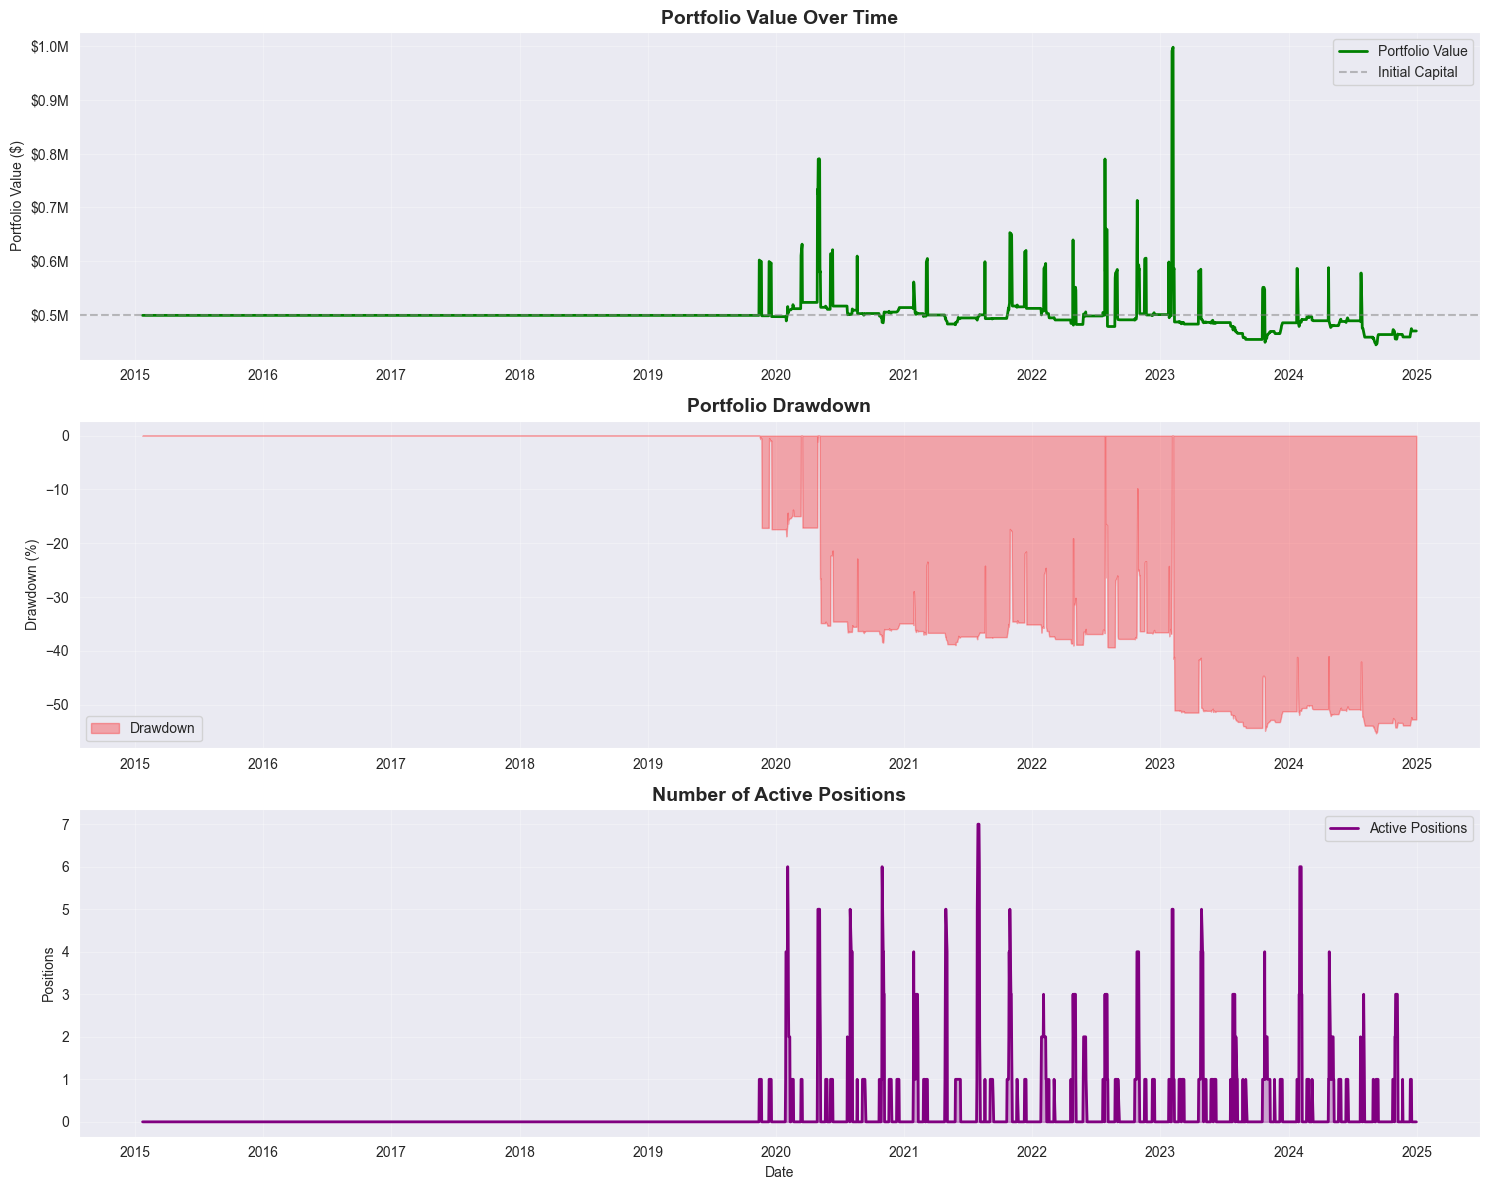


PORTFOLIO PERFORMANCE SUMMARY

Returns:
  Total Return..................      -5.79%
  Annualized Return.............      -0.60%
  Final Portfolio Value......... $   471,067

Risk Metrics:
  Annualized Volatility.........      55.11%
  Maximum Drawdown..............     -55.34%

Risk-Adjusted Returns:
  Sharpe Ratio..................      -0.01
  Sortino Ratio.................      -0.01
  Calmar Ratio..................      -0.01

Trading Statistics:
  Total Trades..................        182
  Total Events..................        182
  Win Rate......................      41.21%
  Profit Factor.................       0.92
  Avg Win.......................       5.50%
  Avg Loss......................      -3.90%



CALCULATING S&P 500 (SPY) BENCHMARK

✅ SPY Benchmark calculated
Final Value: $1,704,067.95
Total Return: 240.81%


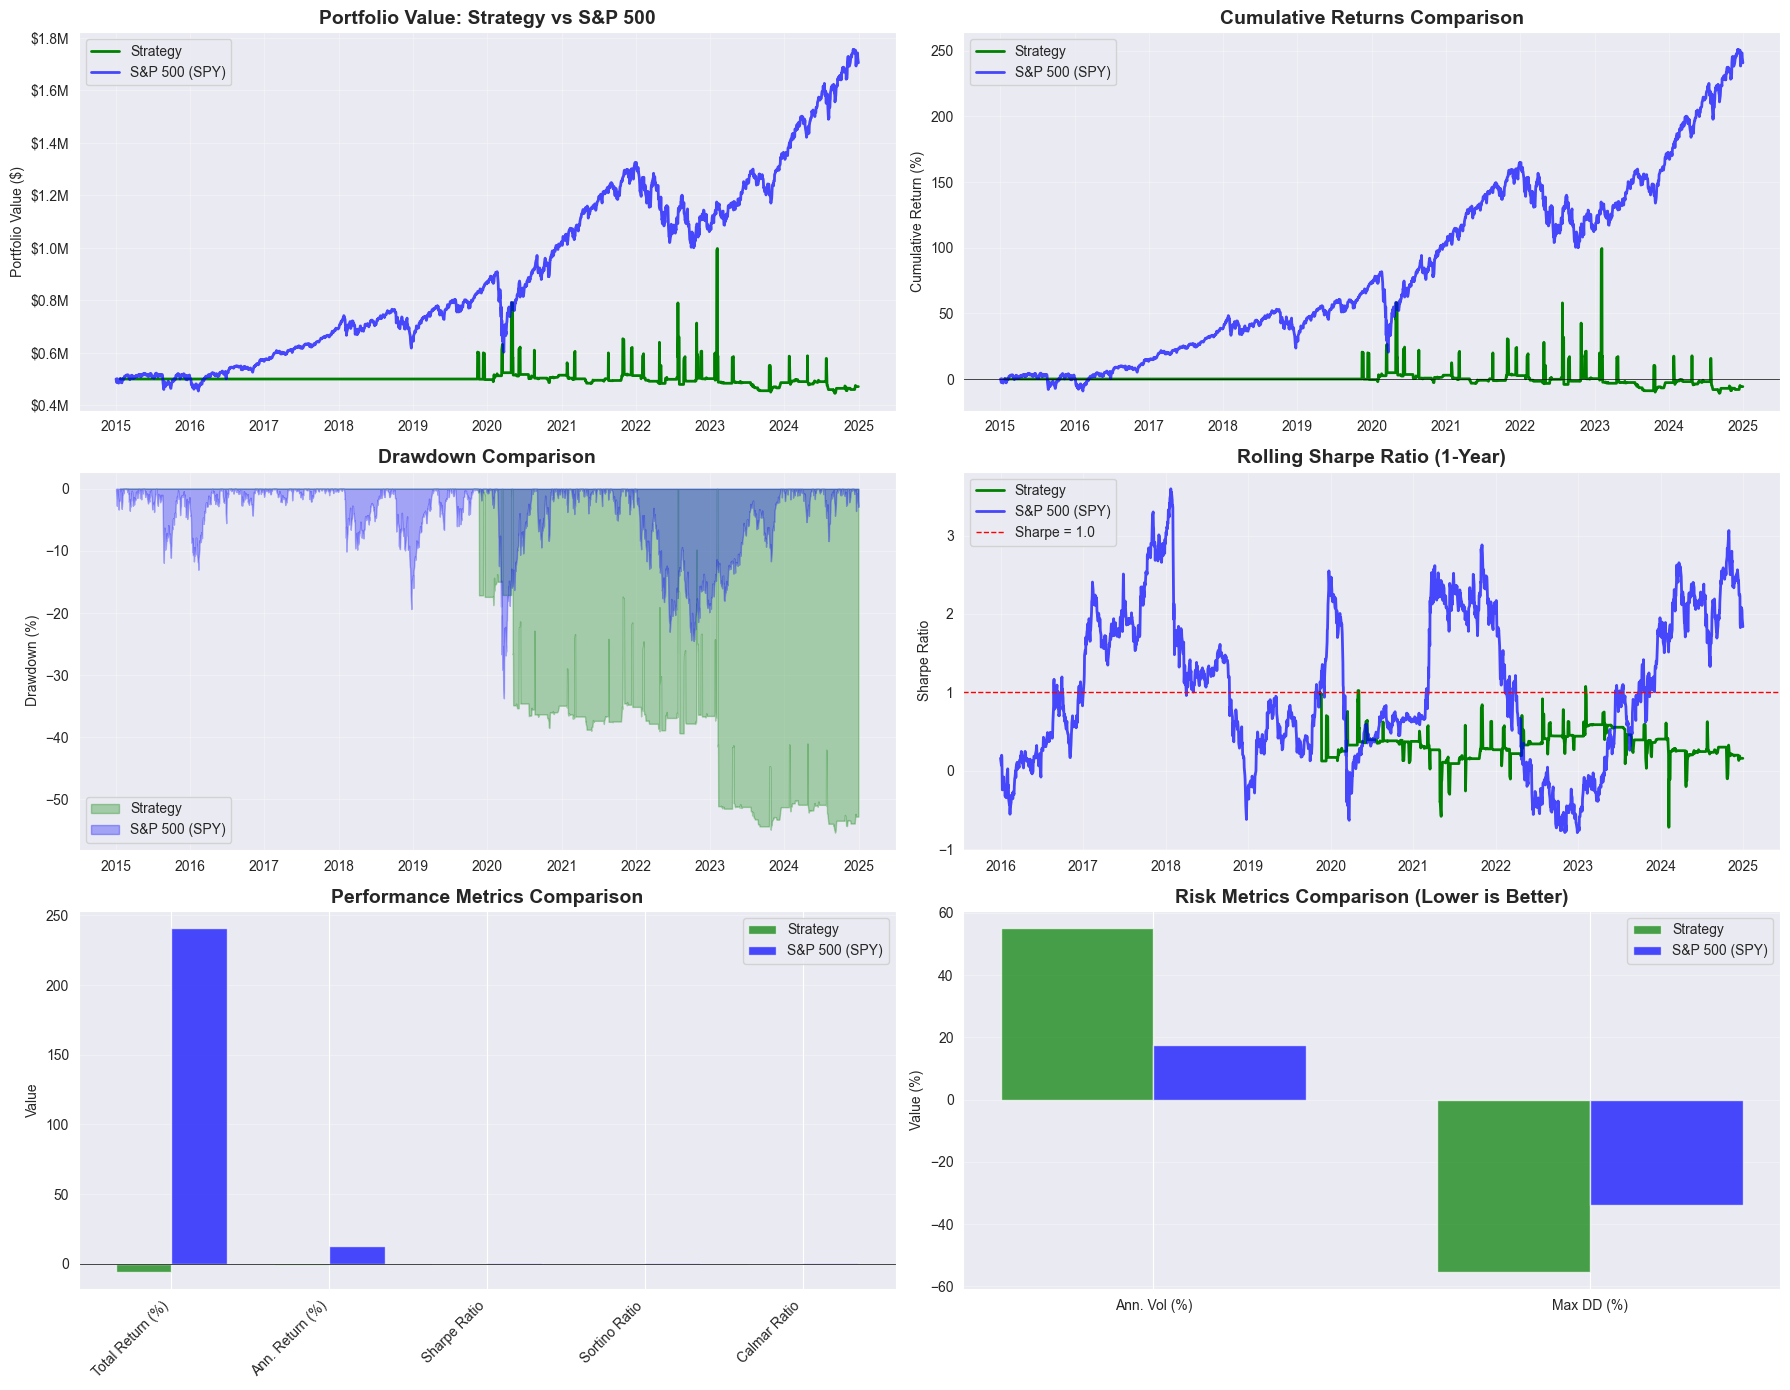


STRATEGY VS S&P 500 (SPY) COMPARISON
Period: 2015-01-01 to 2024-12-31

                       Strategy S&P 500 (SPY)   Difference
Total Return             -5.79%       240.81%     -246.60%
Annualized Return        -0.60%        13.07%      -13.67%
Annualized Volatility    55.11%        17.62%      +37.49%
Sharpe Ratio              -0.01          0.74        -0.75
Sortino Ratio             -0.01         0.90%        -0.90
Max Drawdown            -55.34%       -33.72%      -21.62%
Calmar Ratio              -0.01          0.39        -0.40
Final Value            $471,067    $1,704,068  $-1,233,001

WINNER DETERMINATION
❌ S&P 500 has HIGHER total return
❌ S&P 500 has BETTER risk-adjusted returns (Sharpe)
❌ S&P 500 has LOWER maximum drawdown
❌ S&P 500 has LOWER volatility

🏆 S&P 500 WINS: 4 vs 0
❌ The S&P 500 (SPY) benchmark OUTPERFORMS your strategy



In [55]:
# Define parameters for the backtest
start_date = "2015-01-01"
end_date = "2024-12-31"
stock_list = ['NVDA','AAPL', 'MSFT', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B']
# get_spy_stocks(top_n=50) # Use top 50 liquid stocks

# Strategy parameters from StrategyConfig
strategy_params = {
    'initial_capital': 500000.0,
    'transaction_cost': 0.001, # 0.1%
    'max_positions': 10,
    'max_position_size': 0.2,
    'stop_loss_pct': 0.05,
    'trailing_stop_pct': 0.03,
    'risk_per_trade': 0.02,
    'holding_period': 5 # Hold for 5 trading days
}

# --- 1. Run the Strategy Backtest ---
results = run_backtest(
    start_date=start_date, 
    end_date=end_date,
    stock_list=stock_list,
    **strategy_params
)

# --- 2. Calculate the S&P 500 (SPY) Benchmark ---
spy_benchmark_results = calculate_sp500_benchmark(
    start_date=start_date,
    end_date=end_date,
    initial_capital=strategy_params['initial_capital']
)

# --- 3. Compare Strategy vs. Benchmark ---
if 'metrics' in results and spy_benchmark_results:
    compare_strategy_vs_benchmark(
        results['metrics'], 
        spy_benchmark_results,
        start_date,
        end_date
    )
else:
    print("\n⚠️ Could not run comparison due to errors in backtest or benchmark calculation.")